In [1]:
pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.6 MB/s eta 0:00:00


In [17]:
import copy
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
from torch import optim, nn
from torch.optim import lr_scheduler
import os
import matplotlib.pyplot as plt
import warnings
import numpy as np

warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:

import torch
from torchvision import datasets, transforms
import os

# 数据集路径
data_dir = "/content/drive/MyDrive/MTB/MTB" #数据集谷歌网盘地址：https://drive.google.com/drive/folders/1GpjwQiQ5FjWnj4LXZ_ettApsOYwlIkqs?usp=sharing

# 图像的大小
img_height = 100
img_width = 100

# 数据预处理
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# 加载数据集
full_dataset = datasets.ImageFolder(data_dir)

# 获取数据集的大小
full_size = len(full_dataset)
train_size = int(0.7 * full_size)  # 假设训练集占80%
val_size = full_size - train_size  # 验证集的大小

# 随机分割数据集
torch.manual_seed(0)  # 设置随机种子以确保结果可重复
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# 将数据增强应用到训练集
train_dataset.dataset.transform = data_transforms['train']

# 创建数据加载器
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = full_dataset.classes

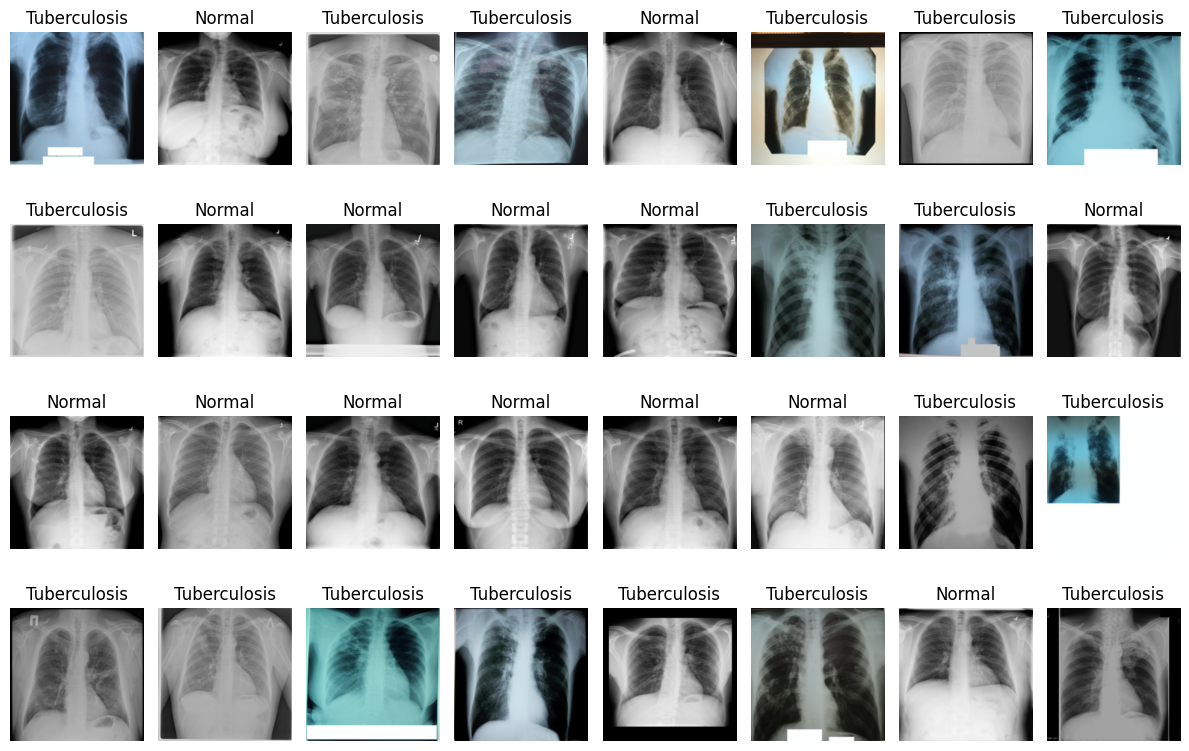

In [16]:

# 获取一个批次的训练图像
inputs, labels = next(iter(train_dataloader))

# 将张量转换为numpy数组
inputs = inputs.numpy()
labels = labels.numpy()

# 获取类别标签的名称
label_names = [class_names[label] for label in labels]

# 显示图像和标签
fig, axes = plt.subplots(figsize=(12, 8), nrows=4, ncols=8)
axes = axes.flatten()

for i, (image, label) in enumerate(zip(inputs, label_names)):
    image = np.transpose(image, (1, 2, 0))  # 调整通道顺序
    image = (image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # 反归一化
    image = np.clip(image, 0, 1)  # 将像素值裁剪到0和1之间

    axes[i].imshow(image)
    axes[i].axis('off')
    axes[i].set_title(label)

plt.tight_layout()
plt.show()

In [18]:

# 定义Vision Transformer模型
import timm
model = timm.create_model('vit_base_patch16_224', pretrained=True)  # 你可以选择适合你需求的Vision Transformer版本，这里以vit_base_patch16_224为例
num_ftrs = model.head.in_features

# 根据分类任务修改最后一层
model.head = nn.Linear(num_ftrs, len(class_names))

model = model.to(device)

# 打印模型摘要
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [19]:
# 定义损失函数
criterion = nn.CrossEntropyLoss()

# 定义优化器
optimizer = optim.Adam(model.parameters())

# 定义学习率调度器
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# 开始训练模型
num_epochs = 10
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

# 初始化记录器
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)

    # 每个epoch都有一个训练和验证阶段
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
        else:
            model.eval()   # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # 遍历数据
        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 零参数梯度
            optimizer.zero_grad()

            # 前向
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # 只在训练模式下进行反向和优化
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # 统计
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = (running_corrects.double() / dataset_sizes[phase]).item()

        # 记录每个epoch的loss和accuracy
        if phase == 'train':
            train_loss_history.append(epoch_loss)
            train_acc_history.append(epoch_acc)
        else:
            val_loss_history.append(epoch_loss)
            val_acc_history.append(epoch_acc)

        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

        # 深拷贝模型
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    print()

print('Best val Acc: {:4f}'.format(best_acc))

Epoch 0/9
----------
train Loss: 1.3085 Acc: 0.5643
val Loss: 0.3523 Acc: 0.8875

Epoch 1/9
----------
train Loss: 0.9429 Acc: 0.7223
val Loss: 0.6723 Acc: 0.6167

Epoch 2/9
----------
train Loss: 0.5467 Acc: 0.7455
val Loss: 0.3454 Acc: 0.8792

Epoch 3/9
----------
train Loss: 0.3227 Acc: 0.8571
val Loss: 0.2602 Acc: 0.9021

Epoch 4/9
----------
train Loss: 0.2511 Acc: 0.9000
val Loss: 0.7689 Acc: 0.7604

Epoch 5/9
----------
train Loss: 0.2781 Acc: 0.8857
val Loss: 0.2552 Acc: 0.9021

Epoch 6/9
----------
train Loss: 0.1734 Acc: 0.9339
val Loss: 0.2189 Acc: 0.9104

Epoch 7/9
----------
train Loss: 0.1492 Acc: 0.9384
val Loss: 0.2991 Acc: 0.9021

Epoch 8/9
----------
train Loss: 0.2004 Acc: 0.9214
val Loss: 0.2115 Acc: 0.9333

Epoch 9/9
----------
train Loss: 0.1754 Acc: 0.9339
val Loss: 0.2287 Acc: 0.9167

Best val Acc: 0.933333


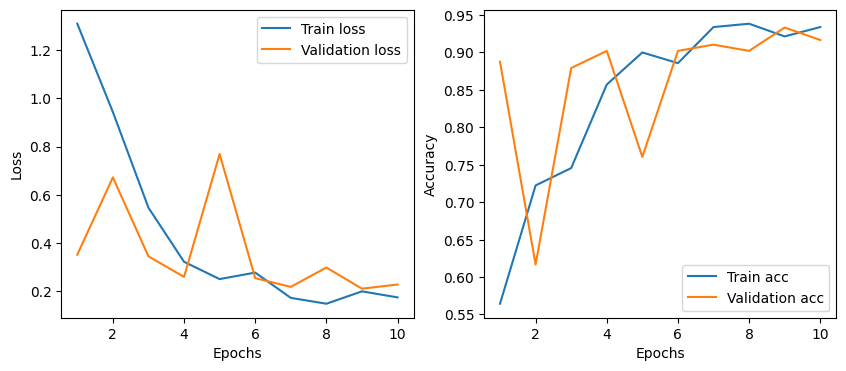

In [20]:
epoch = range(1, len(train_loss_history)+1)

fig, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(epoch, train_loss_history, label='Train loss')
ax[0].plot(epoch, val_loss_history, label='Validation loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epoch, train_acc_history, label='Train acc')
ax[1].plot(epoch, val_acc_history, label='Validation acc')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()

#plt.savefig("loss-acc.pdf", dpi=300,format="pdf")

验证集的灵敏度为： 0.9035532994923858 验证集的特异度为： 0.9257950530035336 验证集的准确率为： 0.9166666666666666 验证集的错误率为： 0.08333333333333337 验证集的精确度为： 0.8944723618090452 验证集的F1为： 0.8989898989898991 验证集的MCC为： 0.8281015908408783


训练集的灵敏度为： 0.952286282306163 训练集的特异度为： 0.9724473257698542 训练集的准确率为： 0.9633928571428572 训练集的错误率为： 0.03660714285714284 训练集的精确度为： 0.9657258064516129 训练集的F1为： 0.9589589589589589 训练集的MCC为： 0.9259980735284651


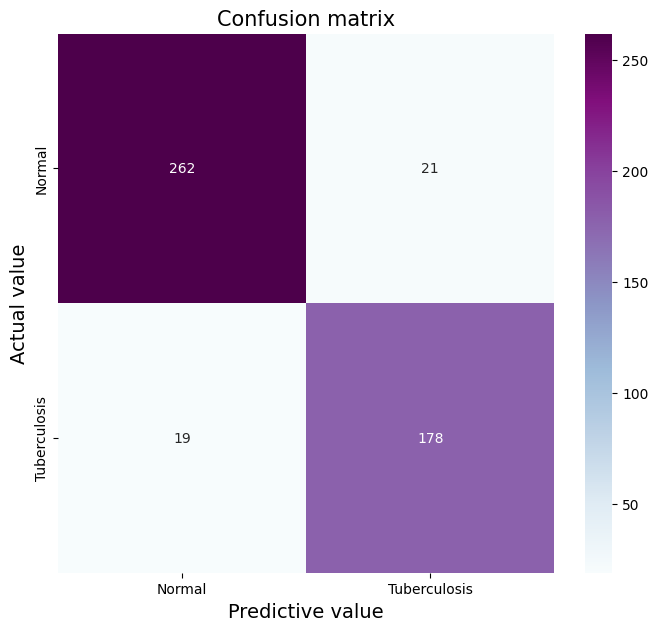

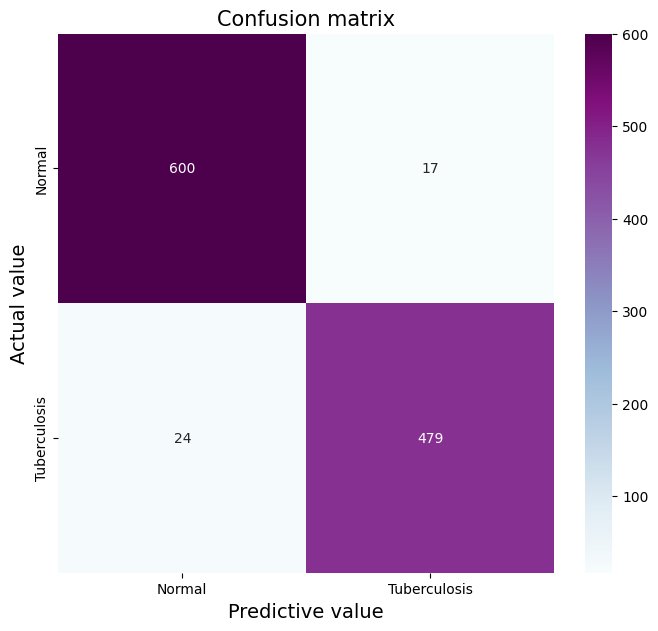

In [21]:

from sklearn.metrics import classification_report, confusion_matrix
import math
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import imshow

# 定义一个绘制混淆矩阵图的函数
def plot_cm(labels, predictions):

    # 生成混淆矩阵
    conf_numpy = confusion_matrix(labels, predictions)
    # 将矩阵转化为 DataFrame
    conf_df = pd.DataFrame(conf_numpy, index=class_names ,columns=class_names)

    plt.figure(figsize=(8,7))

    sns.heatmap(conf_df, annot=True, fmt="d", cmap="BuPu")

    plt.title('Confusion matrix',fontsize=15)
    plt.ylabel('Actual value',fontsize=14)
    plt.xlabel('Predictive value',fontsize=14)

def evaluate_model(model, dataloader, device):
    model.eval()   # 设置模型为评估模式
    true_labels = []
    pred_labels = []
    # 遍历数据
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 前向
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(preds.cpu().numpy())

    return true_labels, pred_labels

# 获取预测和真实标签
true_labels, pred_labels = evaluate_model(model, dataloaders['val'], device)

# 计算混淆矩阵
cm_val = confusion_matrix(true_labels, pred_labels)
a_val = cm_val[0,0]
b_val = cm_val[0,1]
c_val = cm_val[1,0]
d_val = cm_val[1,1]

# 计算各种性能指标
acc_val = (a_val+d_val)/(a_val+b_val+c_val+d_val)  # 准确率
error_rate_val = 1 - acc_val  # 错误率
sen_val = d_val/(d_val+c_val)  # 灵敏度
sep_val = a_val/(a_val+b_val)  # 特异度
precision_val = d_val/(b_val+d_val)  # 精确度
F1_val = (2*precision_val*sen_val)/(precision_val+sen_val)  # F1值
MCC_val = (d_val*a_val-b_val*c_val) / (np.sqrt((d_val+b_val)*(d_val+c_val)*(a_val+b_val)*(a_val+c_val)))  # 马修斯相关系数

# 打印出性能指标
print("验证集的灵敏度为：", sen_val,
      "验证集的特异度为：", sep_val,
      "验证集的准确率为：", acc_val,
      "验证集的错误率为：", error_rate_val,
      "验证集的精确度为：", precision_val,
      "验证集的F1为：", F1_val,
      "验证集的MCC为：", MCC_val)

# 绘制混淆矩阵
plot_cm(true_labels, pred_labels)


# 获取预测和真实标签
train_true_labels, train_pred_labels = evaluate_model(model, dataloaders['train'], device)
# 计算混淆矩阵
cm_train = confusion_matrix(train_true_labels, train_pred_labels)
a_train = cm_train[0,0]
b_train = cm_train[0,1]
c_train = cm_train[1,0]
d_train = cm_train[1,1]
acc_train = (a_train+d_train)/(a_train+b_train+c_train+d_train)
error_rate_train = 1 - acc_train
sen_train = d_train/(d_train+c_train)
sep_train = a_train/(a_train+b_train)
precision_train = d_train/(b_train+d_train)
F1_train = (2*precision_train*sen_train)/(precision_train+sen_train)
MCC_train = (d_train*a_train-b_train*c_train) / (math.sqrt((d_train+b_train)*(d_train+c_train)*(a_train+b_train)*(a_train+c_train)))
print("训练集的灵敏度为：",sen_train,
      "训练集的特异度为：",sep_train,
      "训练集的准确率为：",acc_train,
      "训练集的错误率为：",error_rate_train,
      "训练集的精确度为：",precision_train,
      "训练集的F1为：",F1_train,
      "训练集的MCC为：",MCC_train)

# 绘制混淆矩阵
plot_cm(train_true_labels, train_pred_labels)

训练集的AUC值为： 0.9922861534198375 验证集的AUC值为： 0.964861616831985


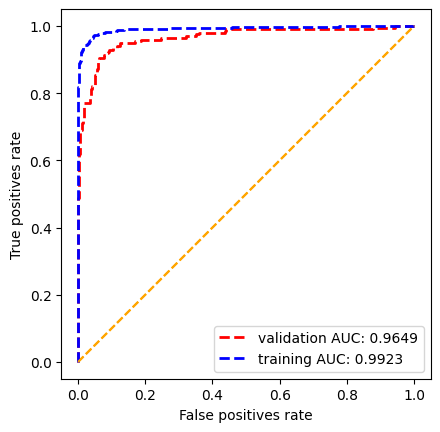

In [22]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
import math

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = metrics.roc_curve(labels, predictions)

    plt.plot(fp, tp, label=name, linewidth=2, **kwargs)
    plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
    plt.xlabel('False positives rate')
    plt.ylabel('True positives rate')
    ax = plt.gca()
    ax.set_aspect('equal')


# 确保模型处于评估模式
model.eval()

train_ds = dataloaders['train']
val_ds = dataloaders['val']

val_pre_auc   = []
val_label_auc = []

for images, labels in val_ds:
    for image, label in zip(images, labels):
        img_array = image.unsqueeze(0).to(device)  # 在第0维增加一个维度并将图像转移到适当的设备上
        prediction_auc = model(img_array)  # 使用模型进行预测
        val_pre_auc.append(prediction_auc.detach().cpu().numpy()[:,1])
        val_label_auc.append(label.item())  # 使用Tensor.item()获取Tensor的值
auc_score_val = metrics.roc_auc_score(val_label_auc, val_pre_auc)


train_pre_auc   = []
train_label_auc = []

for images, labels in train_ds:
    for image, label in zip(images, labels):
        img_array_train = image.unsqueeze(0).to(device)
        prediction_auc = model(img_array_train)
        train_pre_auc.append(prediction_auc.detach().cpu().numpy()[:,1])  # 输出概率而不是标签！
        train_label_auc.append(label.item())
auc_score_train = metrics.roc_auc_score(train_label_auc, train_pre_auc)

plot_roc('validation AUC: {0:.4f}'.format(auc_score_val), val_label_auc , val_pre_auc , color="red", linestyle='--')
plot_roc('training AUC: {0:.4f}'.format(auc_score_train), train_label_auc, train_pre_auc, color="blue", linestyle='--')
plt.legend(loc='lower right')
#plt.savefig("roc.pdf", dpi=300,format="pdf")

print("训练集的AUC值为：",auc_score_train, "验证集的AUC值为：",auc_score_val)